In [1]:
import numpy as np
import random
import time
import sklearn
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
tol = 10**(-10)

In [2]:
def kernel_expo(x,y,gamma):
    return np.exp(-gamma*(np.linalg.norm(x-y)**2))

In [3]:
def KKTviol(O,rho,mu,l,alpha,ens):
    ens2 = np.where(np.logical_or((rho-O[ens])*(1/(mu*l)-alpha[ens])>tol, (O[ens]-rho)*alpha[ens]>tol))
    #print(ens2[0])
    #np.random.shuffle(ens)
    #p = -1
    #enstest = []
    #for index in ens:
    #    if (O[index] -rho)*alpha[index]>tol or (rho-O[index])*(1/(mu*l)-alpha[index])>tol:
    #        #print((O[index] -rho)*alpha[index],(rho-O[index])*(1/(mu*l)-alpha[index]),alpha[index])
    #        enstest.append(index)
    #        p = index
    
    if len(ens2[0]) == 0:
        return -1
    else :
        index = np.random.randint(len(ens2[0]))
        #print(ens2[0][index])
        #print(ens2[0])
        #print(len(ens2[0]))
        #print(ens2)
        #print(enstest)
        #print(len(ens))
        #time.sleep(0.5)
        return ens[ens2[0][index]]
    #return p

In [4]:
def argmax(O,i,ens):
    index = 0
    value = 0
    ens = list(ens)
    Oens = O[ens]
    #print(len(ens))
    #print(ens[np.argmax(O[i]-Oens)])
    #print(ens)
    #time.sleep(0.5)
    return ens[np.argmax(O[i]-Oens)]

In [5]:
def optim(alpha,i,j,K,O,mu,l):
    delta = alpha[i]+alpha[j]
    Ci = O[i] - alpha[i]*K[i,i] -alpha[j]*K[i,j]
    Cj = O[j] - alpha[i]*K[i,j] -alpha[j]*K[j,j]
    # Condition droite (inutile dans le cas du noyau gaussien)
    if K[i,i]+K[j,j]-2*K[i,j] == 0:
        if Cj-Ci-K[i,i]>0:
            alphaj = max(0,delta-1/(l*mu))
            alphai = delta - alphaj
        elif Cj-Ci-K[i,i] <0:
            alphaj = min(1/(l*mu),delta)
            alphai = delta - alphaj
        else :
            alphaj = alpha[j]
            alphai = alpha[i]
    else:
        xmin =  (delta*(K[i,i]-K[i,j])+Ci-Cj)/( K[i,i]+K[j,j]-2*K[i,j])
        
        # condition si le min n'est pas atteint dans 0 1/(l*mu)
        # condition sur K inutile si noyau gaussien
        if K[i,i]+K[j,j]-2*K[i,j] < 0 or xmin <max(0,delta-1/(mu*l)) or xmin > min(1/(mu*l),delta):
            #print("sur les bords",K[i,i]+K[j,j]-2*K[i,j],xmin)
            #time.sleep(1)
            x0 = max(0,delta-1/(l*mu))
            fx0  = 1/2*(delta-x0)**2*K[i,i] + (delta-x0)*K[i,j] + 1/2*x0**2*K[j,j] + (delta-x0)*Ci + x0*Cj
            xmu = min(1/(l*mu),delta)
            fxmu  = 1/2*(delta-xmu)**2*K[i,i] + (delta-xmu)*K[i,j] + 1/2*xmu**2*K[j,j] + (delta-xmu)*Ci + xmu*Cj
            if fx0 > fxmu:
                alphaj = xmu
                alphai = delta - alphaj
            else :
                alphaj = x0
                alphai = delta - alphaj
        else :
            #print("A l'intérieur",xmin)
            #time.sleep(1)
            alphaj = xmin
            alphai = delta - alphaj
        """
        alphaj = alpha[j] + (O[i]-O[j])/(K[i,i]+K[j,j]-2*K[i,j])
        if alphaj < 0:
            alphaj = 0
        if alphaj >1/(l*mu):
            #print("l",l,mu)
            alphaj = 1/(l*mu)
        delta = alpha[i]+alpha[j]
        alphai = delta - alphaj
        """
    alphai = delta - alphaj
    #print(alphai,alphaj)
    #print("alphai , alphaj : ",alphai,alphaj,alpha[i],alpha[j] , " delta : ", delta)
    if alpha[i]+alpha[j] - (alphai + alphaj)>10**(-8):
        print("delta : ",alpha[i]+alpha[j], alphai + alphaj)
        print(alpha[i],alpha[j],alphai,alphaj)
    if alphai<0 or alphaj <0 or alphai >1/(mu*l) or alphaj >1/(mu*l):
        print("oups",alphai,alphaj)
    return alphai,alphaj
    

In [21]:
def SVcalc(alpha,c=1):
    SV = list(np.where(((alpha>tol) & (alpha<(c-tol))))[0])
    #print(len(SV))
    #time.sleep(0.3)
    return SV

In [46]:
class osvm:
    def __init__(self,mu=0.01,maxiter=1000,maxiterii = 100,eps=0.001,gamma=5):
        assert mu>0,"mu doit être strictement positif"
        assert mu<=1,"mu doit être inférieur à 1"
        self.mu = mu
        self.eps = eps
        self.maxiter = maxiter
        self.maxiterii = maxiterii
        self.gamma = gamma
        self.time_init = 0
        self.time_kkt = 0
        self.time_O = 0
        self.time_sv = 0
        self.time_argmax = 0
        self.len_sv = []
        self.index_hist = []
        self.i_hist = []
        self.O_hist = []
        self.diff_hist = []
        self.diffi_hist = []
        self.lenOsv = []
        self.sv_hist = []
        self.diffindex_hist = []
        self.rho_hist = []
        self.kkt_hist = []
        
    def fit(self,data):
        print("Initialisation")
        timer = time.clock()
        self.alpha = np.zeros(np.shape(data)[0])
        self.l = np.shape(data)[0] 
        l = self.l
        self.data = data
        K = np.array([[kernel_expo(x,y,self.gamma) for x in data] for y in data])
        choose = [i for i in range(l)]
        self.rho = 0
        s = 0
        while s <= 1-1/(l*self.mu):
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1/(l*self.mu)
            s += 1/(l*self.mu)
        if s != 1:
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1-s
            #print(1-s)
            s = 1
        #C = np.dot(self.alpha[2:],K[2:,:])
        self.time_init += time.clock()-timer
        timer = time.clock()
        O = np.dot(self.alpha,K)
        self.time_O += time.clock()-timer
        self.rho = max(O[self.alpha>tol])
        self.rho_hist.append(self.rho)
        #print(sum(self.alpha))
        print("Apprentissage")
        iter_etape = 0
        iteration = 0
        while iteration < self.maxiter:
            #self.len_sv = []
            #self.index_hist = []
            #self.i_hist = []
            self.O_hist = []
            self.diff_hist = []
            self.diffi_hist = []
            self.lenOsv = []
            self.sv_hist = []
            self.diffindex_hist = []
            #self.rho_hist = []

            # Etape (i)
            timer = time.clock()
            enskkt = list(range(l))
            np.random.shuffle(enskkt)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,enskkt)
            self.kkt_hist.append(len(np.where(np.logical_or((self.rho-O[enskkt])*(1/(self.mu*l)-self.alpha[enskkt])>tol, 
                                                            (O[enskkt]-self.rho)*self.alpha[enskkt]>tol))))
            self.time_kkt += time.clock() - timer
            iteration += 1
            if index == -1:
                print(iteration,"break index")
                break
            
            timer = time.clock()
            if iteration == 1 :
                SV = SVcalc(self.alpha)
            else:
                SV = SVcalc(self.alpha,1/(self.mu*l))
            self.time_sv += time.clock() - timer
            
            """if SV == []:
                SV_rand = np.random.randint(len(self.alpha))
                while SV_rand == index:
                    SV_rand = np.random.randint(len(self.alpha))
                SV = [SV_rand]"""
            while index in SV:
                    SV.remove(index)
            if SV == []:
                SV = SVcalc(self.alpha)
                while index in SV:
                    SV.remove(index)
            if SV ==[]:
                continue
            
            self.time_argmax -= time.clock()
            j = argmax(O,index,SV)
            self.time_argmax += time.clock()
            self.i_hist.append(j)
            #print("before",self.alpha[index],self.alpha[j])
            alpha_index,alpha_j = self.alpha[index],self.alpha[j]
            self.alpha[index],self.alpha[j] = optim(self.alpha,index,j,K,O,self.mu,l)
            if sum(self.alpha) > 1.001:
                print("etape i " ,sum(self.alpha))
                time.sleep(0.5)
            #print("after",self.alpha[index],self.alpha[j])
            
            # update de rho
            self.time_O -= time.clock()
            O += K[index,:]*(self.alpha[index]-alpha_index) + K[j,:]*(self.alpha[j]-alpha_j)
            try:
                self.rho = max(O[ ((self.alpha>tol) & (self.alpha< (1/(l*self.mu)-tol)))])
            except:
                print("rho out")
                try :
                    self.rho = max(O[ (self.alpha>tol )]) 
                except :
                    print("rho break")
                    break
            self.rho_hist.append(self.rho)
            self.time_O += time.clock()
            self.time_sv -= time.clock()
            SV = SVcalc(self.alpha,1/(self.mu*l))
            self.time_sv += time.clock()
            
            # Etape (ii)
            self.time_kkt -= time.clock()
            np.random.shuffle(SV)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
            self.kkt_hist.append(len(np.where(np.logical_or((self.rho-O[SV])*(1/(self.mu*l)-self.alpha[SV])>tol, 
                                                            (O[SV]-self.rho)*self.alpha[SV]>tol))))
            self.time_kkt += time.clock()
            iterii = 0
            while index !=-1 and len(SV)>=1 and iterii < self.maxiterii:
                iterii += 1
                while index in SV:
                    SV.remove(index)
                    #if iter_etape> 2000:
                    #    print(SV)
                    #    print(index)
                    #    time.sleep(0.5)
                if SV != []:
                    iter_etape += 1
                    self.len_sv.append(len(SV))
                    self.index_hist.append(index)
                    self.time_argmax -= time.clock()
                    j = argmax(O,index,SV)
                    Osv = O[index] - O
                    self.i_hist.append(j)
                    self.diff_hist.append(max(abs(Osv[SV])))
                    self.diffi_hist.append(np.argmax(abs(Osv[SV])))
                    self.index_hist.append(index)
                    self.lenOsv.append(len(Osv[SV]))
                    self.sv_hist.append(SV)
                    self.time_argmax += time.clock()
                    #print("j " , j)
                    #time.sleep(0.5)
                    #print("before",self.alpha[index],self.alpha[j])
                    delta = self.alpha[index] + self.alpha[j]
                    #self.alpha[index],self.alpha[j] 
                    alpha_index,alpha_j = self.alpha[index],self.alpha[j]
                    self.alpha[index] , self.alpha[j] = optim(self.alpha,index,j,K,O,self.mu,l)
                    #if sum(self.alpha) > 1.001:
                    #    print("etape ii " ,sum(self.alpha))
                    #    print(index,j)
                    #    print(self.alpha[index] + self.alpha[j] , delta, alpha_index + alpha_j)
                    #    print(SV)
                    #    time.sleep(0.5)
                    #print("after",self.alpha[index],self.alpha[j])
                    #time.sleep(0.5)
                    # update de rho
                    #print(np.size(self.alpha),np.size(K))
                    self.time_O -= time.clock()
                    O += K[index,:]*(self.alpha[index]-alpha_index) + K[j,:]*(self.alpha[j]-alpha_j)
                    self.rho = max(O[ ((self.alpha>tol) & (self.alpha< (1/(l*self.mu)-tol)))])
                    self.rho_hist.append(self.rho)
                    self.time_O += time.clock()
                    self.O_hist.append(np.linalg.norm(K[index,:]*(self.alpha[index]-alpha_index) + K[j,:]*(self.alpha[j]-alpha_j)))
                    self.O = O
                    self.K = K
                    self.time_sv -= time.clock()
                    SV = SVcalc(self.alpha,1/(self.mu*l))
                    self.time_sv += time.clock()
                else:
                    continue
                    
                
                #print(index)
                
                if len(SV) == 1:
                    print("len sv break")
                    break
                #print(" longueur sv " ,len(SV))
                self.time_kkt -= time.clock()
                np.random.shuffle(SV)            
                index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
                self.kkt_hist.append(len(np.where(np.logical_or((self.rho-O[enskkt])*(1/(self.mu*l)-self.alpha[enskkt])>tol, 
                                                            (O[enskkt]-self.rho)*self.alpha[enskkt]>tol))))
                if index == -1:
                    break
                self.time_kkt += time.clock()
                while index in SV:
                    SV.remove(index)
                
            #if iterii == maxiterii :
            #    continue
                """
                rargmax = 0
                rmax = 0
                for i in range(len(self.alpha)):
                    alp = self.alpha[i]
                    if alp >0 and alp < 1*(self.mu*l):
                        print(O[i])
                        if O[i]> rmax:
                            rmax = O[i]
                            rargmax = i
                            """
                #print(min(O[ (self.alpha>0)& (self.alpha < 1/(self.mu*l)) ]),max(O[ (self.alpha>0)& (self.alpha < 1/(self.mu*l)) ]))
                #print("sum : " , sum(self.alpha))
                #print(self.rho,rargmax,O[rargmax],self.alpha[rargmax],rmax)
            if iteration%100 == 0 :
                print(iter_etape,iteration,self.maxiter,self.rho,np.dot(self.alpha,np.dot(self.alpha,K)))
                iter_etape = 0
        #return self.alpha,self.rho    
    
    def predict(self,xi):
        K = np.array([[kernel_expo(x,xie,self.gamma) for xie in xi ]for x in self.data])
        return np.sign(np.dot(self.alpha,K)-self.rho)
    
    def decision_function(self,xi):
        K = np.array([[kernel_expo(x,xie,self.gamma) for xie in xi ]for x in self.data])
        return np.dot(self.alpha,K)-self.rho

In [40]:
data = 2*(-0.5 + np.random.rand(500))

In [47]:
test = osvm(0.0000001,gamma = 100,maxiter=1000,maxiterii=200)
test.fit(data)

Initialisation
Apprentissage
19600 100 1000 0.500244319007 0.274653525046
20000 200 1000 0.500540428645 0.274148932227
20000 300 1000 0.500497494305 0.274036515396
20000 400 1000 0.500559407982 0.274032239207
20000 500 1000 0.500551793456 0.274027808708
20000 600 1000 0.50055625825 0.27402658693
20000 700 1000 0.500556746138 0.274026396069
20000 800 1000 0.500552592618 0.274026241495
20000 900 1000 0.500553214196 0.274026147829
20000 1000 1000 0.500553229467 0.274026140447


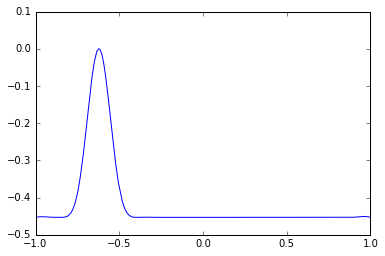

In [48]:
plt.plot(np.sort(data),test.decision_function(np.sort(data)))

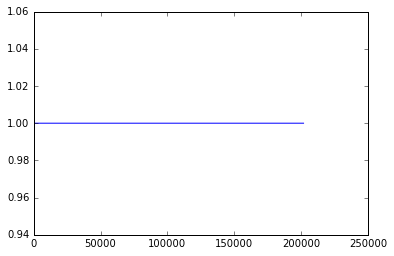

In [49]:
plt.plot(test.kkt_hist)

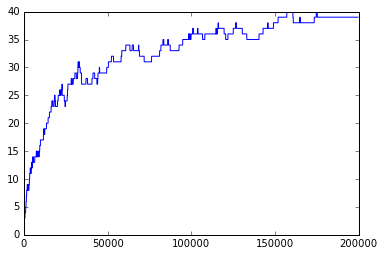

In [50]:
plt.plot(test.len_sv)
#plt.plot(test.lenOsv,'r')
plt.show()

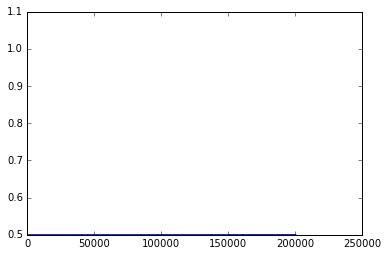

In [51]:
plt.plot(test.rho_hist)
#plt.plot(test.lenOsv,'r')
plt.show()

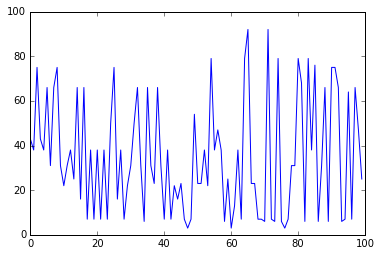

In [36]:

#plt.plot(test.lenOsv,'r')
plt.plot(test.i_hist[-100:])
plt.show()

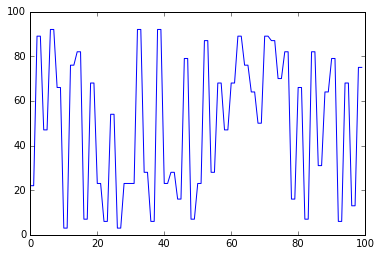

In [37]:
plt.plot(test.index_hist[-100:])
plt.show()

In [38]:
# probleme de la projection de alpha1 et alpha2
#return alpha?
print(np.histogram(test.len_sv,bins = [i for i in range(100)]))

(array([     0,      0,   1000,   2000,   2000,   1984,   1016,   3000,
         1000,   1000,   1000,   1000,   9000,   2000,   2852,   3910,
         1238,   4000,   5000,   6897,  10527,  52553,  12023,  29828,
        13172,  96143, 193745,  40112,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0], dtype=int64), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21,

In [66]:
print(np.where(np.histogram(test.index_hist,bins = [i for i in range(1000)])[0]>0))

(array([ 15,  30,  35,  53,  88,  91, 136, 166, 192, 211, 225, 329, 335,
       379, 407, 419, 487, 541, 563, 574, 579, 594, 636, 646, 717, 752,
       767, 769, 887, 889, 919, 940, 979], dtype=int64),)


In [39]:
print(np.where(test.alpha>0))

(array([ 3,  6,  7,  9, 13, 16, 22, 23, 25, 28, 31, 38, 43, 47, 50, 54, 64,
       66, 68, 70, 75, 76, 77, 79, 82, 87, 89, 92], dtype=int64),)


In [36]:
test.alpha[test.alpha>0]

array([  9.41126276e-03,   1.28420442e-02,   7.30224956e-03,
         9.46904933e-03,   4.66788753e-03,   2.93389126e-02,
         1.59793330e-02,   1.71948687e-02,   5.03977018e-03,
         4.31736332e-02,   2.26125396e-02,   8.93390530e-03,
         1.57304625e-02,   3.00231931e-02,   5.17939806e-03,
         2.36711055e-03,   2.31434075e-02,   3.31537370e-05,
         1.38761792e-03,   5.00000000e-01,   2.59719802e-02,
         5.90793204e-03,   4.69365853e-03,   1.81046437e-02,
         1.18660204e-02,   1.69689190e-03,   1.54702884e-02,
         6.91500579e-03,   1.09062311e-02,   9.15207871e-03,
         2.96858139e-03,   4.98167571e-03,   3.74526416e-02,
         7.49338046e-03,   1.71530505e-02,   1.12949598e-02,
         1.10858194e-02,   1.62251011e-02,   1.68302600e-02])

In [69]:
del test.lenOsv

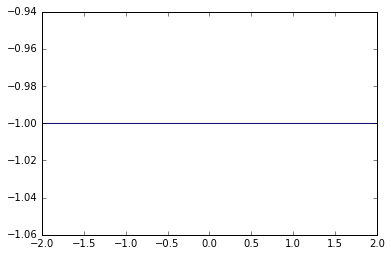

In [37]:
x=np.linspace(-2,2,1000)
y = test.predict(x)
plt.plot(x,y)

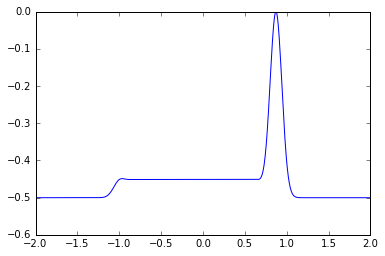

In [38]:
y = test.decision_function(x)
plt.plot(x,y)

In [36]:
xtest=np.linspace(-1,1,1000)

In [37]:
nb = 0
for x in xtest:
    if test.predict(x)<0 :
        nb += 1


TypeError: 'numpy.float64' object is not iterable

In [ ]:
nb

In [13]:
test.rho

0.23332819982247363

KeyboardInterrupt: 

In [94]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = osvm(0.01)
clf.fit(X_train)


Initialisation
Apprentissage


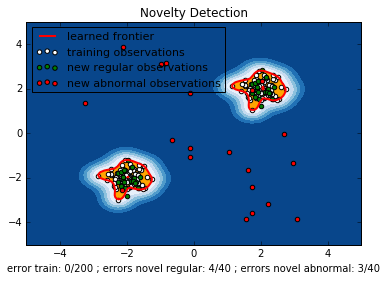

In [95]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

In [47]:
SVcalc(test.alpha,c=1/(1000*0.005))

[61, 270, 322, 481, 910]

In [45]:
test.alpha[61]

0.075695405813604899